# Time Series Forecasting Flu Patterns in the U.S. (2015-2020)
### Andy Nguyen, Michael Wolfe, Joseph Caguioa
### 6/24/20

## Objective
Time series data consists of a ordinal sequence of values collected at successive equally spaced points in time. In contrast to cross-sectional data in which information is collected at a single point in time, time series data can be indexed by the date or time when the information was collected. The goals of time series analysis are typically to determine trends or patterns of the collected data over time and building models to forecast future behavior within confidence limits.

Due to the uncertainty and unpredictable nature of time series (such as stock data), providing confidence limits for forecasted predictions are vital in capturing the viability of models. As with predicting continuous-scaled variables, forecasts accompanied with confidence intervals provide a range of values that the model deems plausible based on the patterns and trends accounted for in the time series.

Long-term time series forecast extending a few years into the future present a tough challenge as they are often imprecise and unreliable since models are only designed to best describe the provided data. Horizons (forecast window n-time points in the future) extending far into the future tend to compound the issues of uncertainty and volatility associated with time series data. Depending on the models used, forecasts may begin to regress towards the mean or continue predicting trends even when not present with large horizons.

The objective of this analysis will be to determine trends and patterns in influenza activity within the United States at a national level over the past 5 years. An auto-regressive integrated moving average (ARIMA) model will then be implemented to forecast future flu cases based on the trends and patterns observed in the time series from 2015-2020. A forecast horizon of only 3 months (12 weeks) into the future will be provided to avoid the challenges associated with long-term forecasts.


## Data Description

<figure class ="image">
<center>
    <img src = "FluView.png">
    <figcaption id = "Figure 1"> Figure 1: Weekly U.S. Influenza Surveillance System </figcaption>
</center>
</figure>

The time series data is obtained from the weekly FluView surveillance report dating back to the 1997-1998 flu season, but only a subset of the data starting in October 2015 to June 2020 will be used in this analysis to capture the most recent trends in influenza activity. These weekly reports are compiled by the CDC to analyze flu activity year round in the United States. Specific details on the data collection methods and purposes of FluView are provided at the following link: https://www.cdc.gov/flu/weekly/overview.htm. 

The surveillance system compiles data from both clinical and public health laboratories. The data used in this analysis is the portion of positive influenza tests reported by U.S. public health laboratories at the national level from 10/4/15 - 6/14/20. In addition to the total number of flu specimens reported in a week, the data set provides specific influenza subtypes and lineages: A (2009 H1N1), A (H3), A (Subtyping not Performed), B, BVic, BYam, and H3N2v. The scope of this analysis will only focus on the total number of flu specimens as a time series so these specific subtypes and lineages will be omitted from this study. However, more in-depth analyses can be conducted using these subtypes and lineages to monitor the proportion of circulating influenza virus types.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
import itertools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import FileLink, FileLinks
from sklearn.metrics import mean_squared_error

In [2]:
rawflu2015 = pd.read_csv('Data/WHO_NREVSS_Public_Health_Labs.csv', sep=',', header=0, skiprows=1)
rawflu2015

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,A (2009 H1N1),A (H3),A (Subtyping not Performed),B,BVic,BYam,H3N2v
0,National,X,2015,40,1139,4,65,2,10,0,1,0
1,National,X,2015,41,1152,5,41,2,7,3,0,0
2,National,X,2015,42,1198,10,50,1,8,3,2,0
3,National,X,2015,43,1244,9,31,4,9,1,4,0
4,National,X,2015,44,1465,4,23,4,9,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
241,National,X,2020,21,536,0,0,1,0,0,0,0
242,National,X,2020,22,515,2,0,1,1,0,0,0
243,National,X,2020,23,322,0,0,0,1,0,0,0
244,National,X,2020,24,305,0,0,0,1,0,0,0


As previously mentioned, the time series will be analyzed at the national level so the Region Type and Region variables are irrelevant and will be removed in processing the data. The date in which reports were compiled (Year and Week) will be used as the date index of the processed FluCases data frame. The processed time series data for total flu cases contains a total of 246 weekly reports from October 2015 to June 2020.

In [3]:
rawflu2015.describe()

,YEAR,WEEK,TOTAL SPECIMENS,A (2009 H1N1),A (H3),A (Subtyping not Performed),B,BVic,BYam,H3N2v
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,2017.621951,26.158537,1895.394309,279.593496,363.264228,18.430894,53.138211,86.260163,88.386179,0.321138
std,1.419746,15.360274,1695.795498,518.371372,700.318574,31.788095,79.264973,217.648072,175.781152,2.099203
min,2015.000000,1.000000,131.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,13.000000,483.000000,9.000000,32.250000,1.000000,3.000000,3.000000,4.000000,0.000000
50%,2018.000000,25.000000,1249.000000,29.000000,68.500000,4.000000,11.500000,17.000000,11.000000,0.000000
75%,2019.000000,40.000000,2982.750000,244.500000,232.750000,21.750000,74.750000,58.000000,62.500000,0.000000
max,2020.000000,52.000000,7056.000000,2339.000000,3336.000000,205.000000,329.000000,1309.000000,931.000000,24.000000


The above summary of the raw imported data describes statistics of cases at the weekly level. Of note, at no week was the reported number of cases ever zero; the minimum is 131. This is corroborated later in Figure 3, a time series plot of total specimens, where the line never dips to the zero tickmark on the y-axis. However, all strains of flu (delinated by the last seven columns above) have at least one week in which the minimum specimens reported is zero.

In [4]:
rawflu2015.isna().any()

REGION TYPE                    False
REGION                         False
YEAR                           False
WEEK                           False
TOTAL SPECIMENS                False
A (2009 H1N1)                  False
A (H3)                         False
A (Subtyping not Performed)    False
B                              False
BVic                           False
BYam                           False
H3N2v                          False
dtype: bool

In [5]:
rawflu2015.iloc[:,4:].isin([0]).sum()

TOTAL SPECIMENS                  0
A (2009 H1N1)                    4
A (H3)                          10
A (Subtyping not Performed)     48
B                               13
BVic                            30
BYam                            25
H3N2v                          233
dtype: int64

An explicit call reveals no null values in any of the columns. Furthermore, the summary statistics shown earlier do not reveal any unusual values such as negative numbers, which are sometimes used to encode missing data. 

Briefly looking closer at the subtypes provides justification for our decision to use total flu specimens instead of drilling down into the subtypes. For starters, H3N2v was rarely reported, with 233 out of 246 weeks (~94%) having zero cases.

<Figure size 432x288 with 0 Axes>

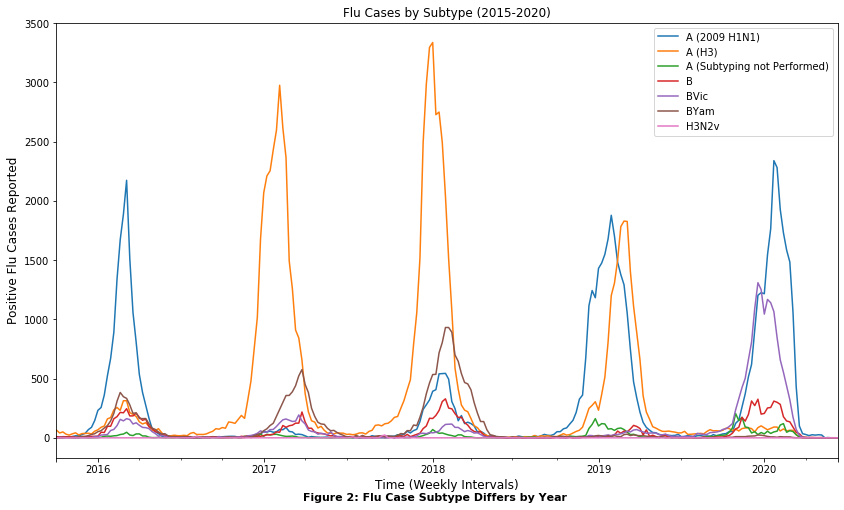

In [6]:
date_index = pd.date_range(start="2015-10-4", end="2020-6-14", freq='W-SUN')
TS_subtype = pd.DataFrame(rawflu2015.iloc[:,5:])
TS_subtype['Dates'] = date_index

fig1 = plt.figure()
sub_ax = TS_subtype.set_index('Dates').plot(figsize=(14,8))
plt.title('Flu Cases by Subtype (2015-2020)')
sub_ax.set_xlabel("Time (Weekly Intervals)", fontsize=12)
sub_ax.set_ylabel("Positive Flu Cases Reported", fontsize=12)
caption2 = "Figure 2: Flu Case Subtype Differs by Year"
plt.figtext(0.5, 0.05, caption2, ha='center', weight='bold', fontsize=11)
plt.show()

Figure 2 plots the reported cases for the declared timespan with colors differentiating the subtypes. This reveals behavior that would be potentially difficult to model at the subtype level due to somewhat unpredictable behavior from year to year. Take Subtype A (2009 H1N1), which is represented by the blue line. It appears to cycle as the biggest cause of case spikes in 2016, 2019, and 2020, yet has a diminished presence in 2017 and 2018. The other large contributor, A (H3), represented by the orange line, sees large spikes in 2017 and 2018, a middling one in 2019, and small ones in 2016 and 2020. This phenomena could have valid and useful real-world explanations, but in the scope of time series modeling, this unpredictability is problematic.

Behavior for other subtypes may look more stable from year to year (look for example at B, encoded by the red line), and thus be potentially more amenable to modeling. However, considering the two named A subtypes are the most responsible within this specific timespan, it naturally follows that they should be included in some capacity. Thus, modeling that looks at the total specimen count for all cases, regardless of subtype, makes the most sense and is the focal point of our analysis.


In [7]:
date_index = pd.date_range(start="2015-10-4", end="2020-6-14", freq='W-SUN')
TS = pd.DataFrame(rawflu2015['TOTAL SPECIMENS'])
FluCases2015 = TS.set_index(date_index)
FluCases2015

,TOTAL SPECIMENS
2015-10-04,1139
2015-10-11,1152
2015-10-18,1198
2015-10-25,1244
2015-11-01,1465
...,...
2020-05-17,536
2020-05-24,515
2020-05-31,322
2020-06-07,305


## Exploratory Data Analysis

<Figure size 432x288 with 0 Axes>

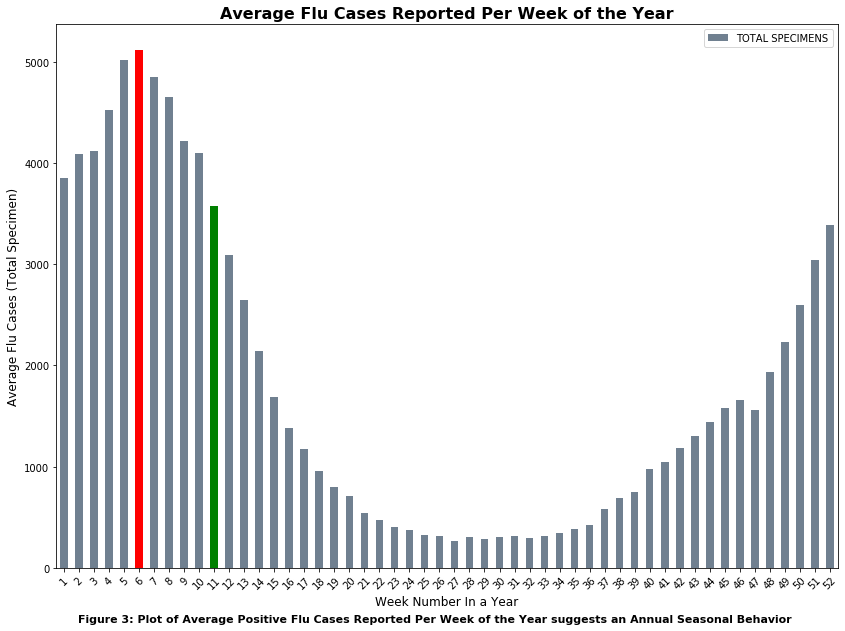

In [8]:
WeekAggregate2015 = rawflu2015[['TOTAL SPECIMENS','WEEK']].groupby('WEEK').mean()
fig2 = plt.figure()
wAgg_ax = WeekAggregate2015.plot(kind='bar', color='slategrey', figsize=(14,10))
plt.title('Average Flu Cases Reported Per Week of the Year', fontsize=16, weight='bold')
wAgg_ax.set_xlabel("Week Number In a Year", fontsize=12)
wAgg_ax.set_ylabel("Average Flu Cases (Total Specimen)", fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(rotation=45, fontsize=10)
highlightG = 11
highlightR = 6
posG = WeekAggregate2015.index.get_loc(highlightG)
posR = WeekAggregate2015.index.get_loc(highlightR)
wAgg_ax.patches[posG].set_facecolor('green')
wAgg_ax.patches[posR].set_facecolor('red')
caption2 = "Figure 3: Plot of Average Positive Flu Cases Reported Per Week of the Year suggests an Annual Seasonal Behavior"
plt.figtext(0.5, 0.05, caption2, ha='center', weight='bold',fontsize=11)
plt.show()

Aggregating the data by weeks in the year, Figure 2 shows that flu activity begins to increase towards the end of the year (weeks 48-52) and peak on the 6th week of the year or around the middle of February (higlighted in red). Activity begins to fall off again roughly around the 11th week or the end of March (highlighted in green). This suggests that these trends in flu activity over the past 5 years follow a seasonal behavior that cycles annually. From a sanity check perspective, this agrees with conventional knowledge about [flu season in the U.S.](https://www.cdc.gov/flu/about/season/flu-season.htm): cases occur year-round, with increasing activity beginning in the winter that peaks in mid-winter.


### Stationarity Exploration

Forecasting methods for time series are typically based on parametric assumptions in which the statistical properties (mean, variance, autocorrelation structure) of the data are constant over time. Satisfying these constant parametric assumptions indicate a stationary time series that yields stable predictions since these statistical properties are assumed to be the same in future forecasts as in the provided time series (past realizations). 

edit: If these conditions are not met, it is difficult to extrapolate model conclusions into the future because the statistics defining the current time series data can not be used to describe future behavior.

<Figure size 432x288 with 0 Axes>

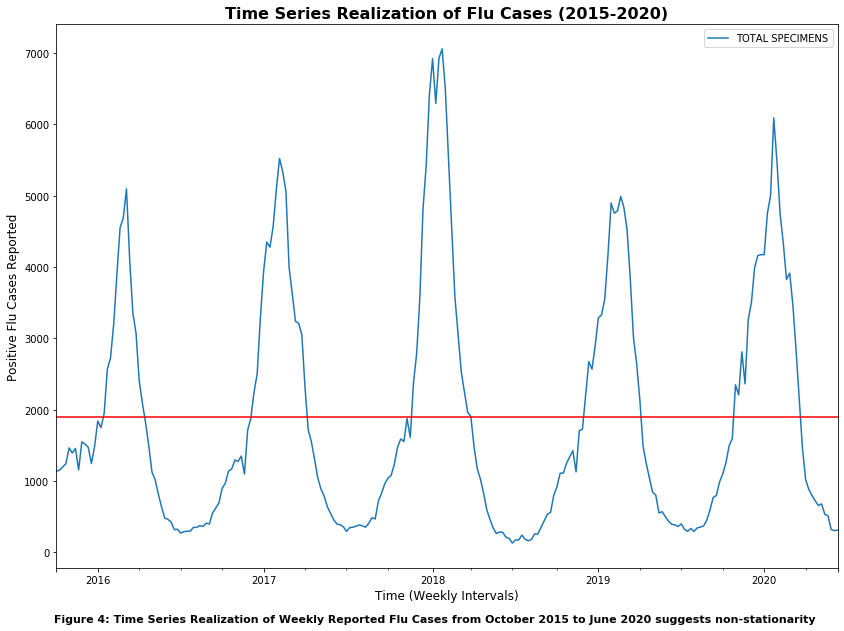

In [9]:
fig3 = plt.figure()
TS_realization = FluCases2015.plot(figsize=(14,10))
plt.axhline(y=FluCases2015['TOTAL SPECIMENS'].mean(), color='red')
plt.title('Time Series Realization of Flu Cases (2015-2020)', fontsize=16, weight='bold')
TS_realization.set_xlabel("Time (Weekly Intervals)", fontsize=12)
TS_realization.set_ylabel("Positive Flu Cases Reported", fontsize=12)
caption3 = "Figure 4: Time Series Realization of Weekly Reported Flu Cases from October 2015 to June 2020 suggests non-stationarity"
plt.figtext(0.5, 0.05, caption3, ha='center', weight='bold',fontsize=11)
plt.show()

Figure 3 shows the realization of the flu activity time series with clear peaks repeating around the beginning of every year, suggesting an annaul trend in the data. This observed annual seasonality indicates that the mean depends on time and is not constant throughout the time series because influenza activity is expected to peak at the beginning of every year. Due to this violation, we suspect that the time series comes from a **non-stationary process**.

Assessing the constant variance assumption over time, the peaks all appear to be approximately the same size despite the pronounced peak at the beginning of 2018. There is some evidence to suggest that the variances do not depend on time, but this is a questional assumption because we can not assume that the mean is constant throughout the time series.

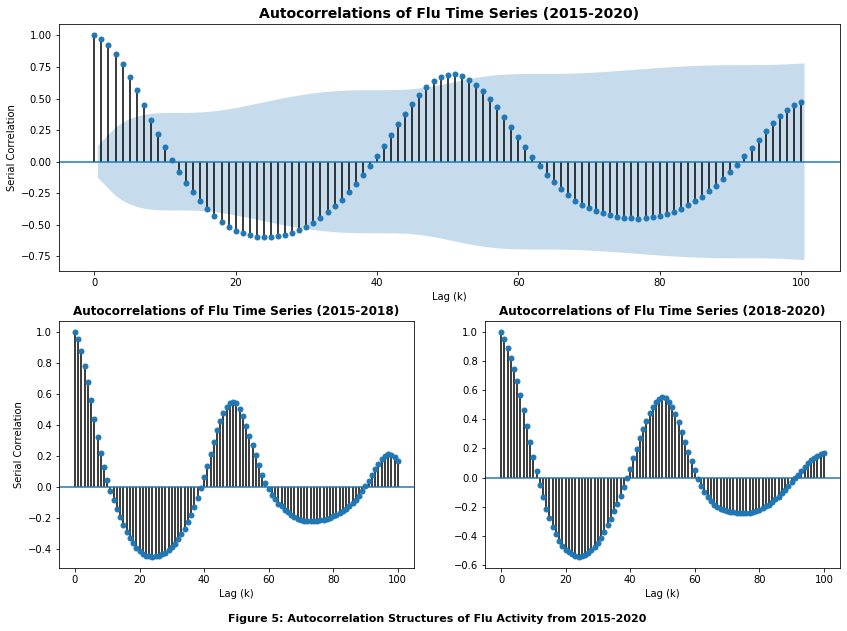

In [10]:
gs = gridspec.GridSpec(2,2)
fig4 = plt.figure(figsize=(14,10))

ax1 = fig4.add_subplot(gs[0,:])
plot_acf(FluCases2015, lags=100, ax=ax1)
ax1.set_title('Autocorrelations of Flu Time Series (2015-2020)',fontsize=14,weight='bold')
ax1.set_xlabel('Lag (k)')
ax1.set_ylabel('Serial Correlation')

ax2 = fig4.add_subplot(gs[1,0])
plot_acf(FluCases2015[0:123], lags=100, alpha=None, ax=ax2)
ax2.set_title("Autocorrelations of Flu Time Series (2015-2018)",fontsize=12,weight='bold')
ax2.set_xlabel('Lag (k)')
ax2.set_ylabel('Serial Correlation')

ax3 = fig4.add_subplot(gs[1,1])
plot_acf(FluCases2015[123:246], lags=100, alpha=None, ax=ax3)
ax3.set_title("Autocorrelations of Flu Time Series (2018-2020)",fontsize=12,weight='bold')
ax3.set_xlabel('Lag (k)')

caption4 = "Figure 5: Autocorrelation Structures of Flu Activity from 2015-2020"
plt.figtext(0.5, 0.05, caption4, ha='center', weight='bold',fontsize=11)
plt.show()

Figure 4 presents the autocorrelation structures of the influenza time series data: full series length from 2015-10-04 to 2020-06-07 (top center), the first half of the series length from 2015-10-04 to 2018-02-04 (bottom left), and the second half of the series length from 2018-02-11 to 2020-06-07 (bottom right). All structures exhibit a similar dampening, sinusodial pattern at each lag in time (t-k), indicating that the autocorrelation structure of the time series is constant over time.

The annual seasonal trend can once again be seen in the following autocorrelation structure with the dampening, sinusodial curve repeating its apex at roughly every 50 lags. The 95% confidence limits (blue shaded region) provide statistical evidence that the serial correlation of flu activity at lags of 50-52 weeks are likely correlated values. This suggests that the number of positive flu cases reported by public health laboratories to the CDC in any given week of a year is highly correlated to the number of positive flu cases reported in that same week of the previous year. Since we expect influenza activity to repeat every year, a seasonal factor of 52 weeks will be implemented into the model to account for this annual trend. 

In [11]:
#Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(FluCases2015, maxlag=0, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -1.573505
p-value                          0.496887
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


Since we suspect flu activity to come from a non-stationary process, the Augmented Dickey-Fuller (ADF) test will be used to verify our observation. The ADF is a unit root test that provides a supported inference on the stationarity since time series containing a unit root is characterstic of non-stationary behavior. The statistical significance test yielded a p-value of 0.49, providing evidence to fail to reject the null hypothesis and suggests that the flu activity time series comes from a non-stationary process.

## ARIMA Model Identification

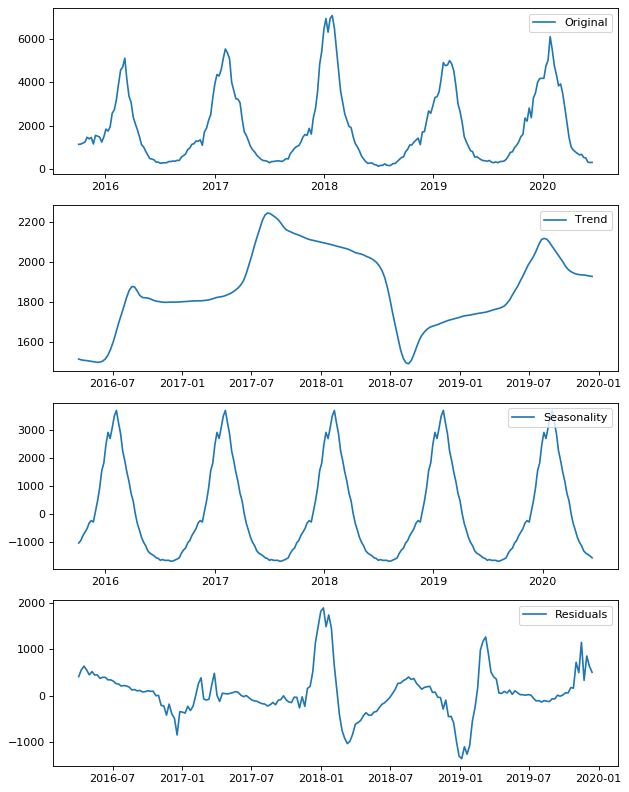

In [12]:
decomposition = seasonal_decompose(FluCases2015)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(num=None, figsize=(8, 10), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(411)
plt.plot(FluCases2015, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Decomposed time series shows annual seasonality repeating at beginning of each year. Trend shows an increase in positive flu cases in the second half of every year and begins to decrease as the new year approaches. This is expected as previously observed in Figure 2 with flu activity increasing at the end of each year and peaking on the 6th week of the year with the highest average of reported flu cases. Activity then begins to noticably decline around the 11th week of year. The decreasing trend seen in the second half of 2018 is most likely a result of a larger amount of reported flu cases in 2018 compared to other years. The residuals do not appear to resemble white noise and carries a bit of the behavior noticed in the trend line.

In [13]:
firstDiff = FluCases2015.diff(1)
#secondDiff = firstDiff.diff(1)
seasonalDiff = FluCases2015.diff(52)
seasonal_firstDiff = seasonalDiff.diff(1)
#seasonal_secondDiff = seasonal_firstDiff.diff(1)
moving_avg = FluCases2015.rolling(52).mean()
#stationary_firstDiff = seasonal_firstDiff - moving_avg
#stationary_secondDiff = seasonal_secondDiff - moving_avg

In [14]:
loss_best = 1E16
best_ints = [-1,-1,-1]
for p in range(6):
    for d in range(2):
        for q in range(3):
            model = ARIMA(seasonal_firstDiff.dropna(), order=(p, d, q), freq='W')  
            try:
                results_ARIMA = model.fit(disp=-1)
            except ValueError:
                pass
            except:
                pass
            x=pd.DataFrame(results_ARIMA.fittedvalues)
            x=x.join(seasonal_firstDiff.dropna())
            x['out']=(x.iloc[:,0]-x.iloc[:,1])**2
            loss=np.sqrt(x['out'].sum())
            if loss < loss_best:
                loss_best = loss
                best_ints=[p,d,q]
print(loss_best)
print(best_ints)

4564.716591736804
[3, 0, 1]


A brute force approach to search for the optimal parameters of the ARIMA model is performed using the residual sum of squares as loss function. The search indicates that an ARIMA(3,1,1) model with a seasonal factor of 52 weeks best describes flu activity in the past 5 years with a minimal loss of 4,565. The first order difference in the original data accounts for the d=1 parameter despite the search yielding a difference value of 0. 

In [15]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(seasonal_firstDiff.dropna(), maxlag=0, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -9.785076e+00
p-value                        6.576443e-17
#Lags Used                     0.000000e+00
Number of Observations Used    1.920000e+02
Critical Value (1%)           -3.464875e+00
Critical Value (5%)           -2.876714e+00
Critical Value (10%)          -2.574859e+00
dtype: float64


Running the Dickey-Fuller test on the data after both a first difference and seasonal difference returns a low p-value, providing evidence of stationarity.

## ARIMA Model

In [16]:
arima = ARIMA(seasonal_firstDiff.dropna(), order=(3,0,1), freq='W')  
results1 = arima.fit()
print('ARIMA{}- AIC:{}'.format((3,0,1), results1.aic))

ARIMA(3, 0, 1)- AIC:2797.082464599613


In [17]:
X = seasonal_firstDiff.dropna().values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    yhat = results1.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
error = mean_squared_error(test, predictions)
print(error)

127005.73491587477


In [18]:
arima = ARIMA(firstDiff.dropna(), order=(5,0,2), freq='W')
results2 = arima.fit()
print('ARIMA{}- AIC:{}'.format((5,0,2), results2.aic))

ARIMA(5, 0, 2)- AIC:3490.1257782417792


In [19]:
def rolling_mse(data, fitted_model, horizon):
    X = data.dropna().values
    train_size = int(len(X) * 0.66)
    mse_list = []
    for i in range(len(X) - (train_size + horizon) + 1):
        train, test = X[0:i+train_size-1], X[i+train_size-1:]
        history = [x for x in train]
        predictions = list()
        for t in range(len(test)):
            yhat = fitted_model.forecast()[0]
            predictions.append(yhat)
            history.append(test[t])
        mse_list.append(mean_squared_error(test, predictions))
    return mse_list

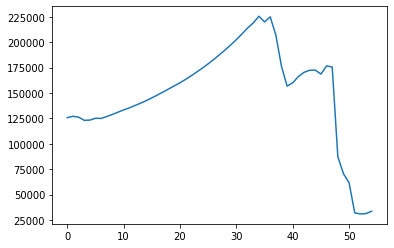

In [20]:
mses = rolling_mse(seasonal_firstDiff, results1, 12) #horizon of 12 since this roughly represents a cycle
plt.plot(mses, label='Rolling Window MSE of ARIMA(3,1,1)')

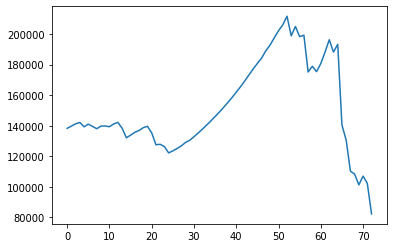

In [21]:
mses = rolling_mse(firstDiff, results2, 12) #horizon of 12 since this roughly represents a cycle
plt.plot(mses, label='Rolling Window MSE of ARIMA(5,1,2)')

It looks like the MSE might fluctuate based on the lag. This could indicate that the forecasts may not be following the trends very well. Let's plot the forecasts to confirm.

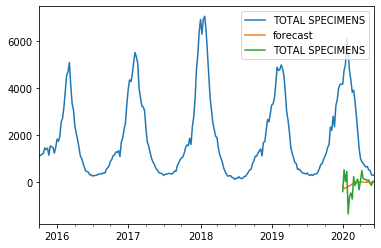

In [22]:
##In sample forecast 3,1,1
fig, ax = plt.subplots()
ax = FluCases2015.loc['2015':].plot(ax=ax)
fig = results1.plot_predict('2020', '2020', dynamic=True, ax=ax, plot_insample=True)
plt.show()

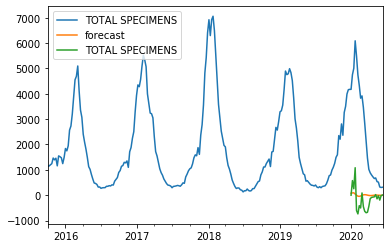

In [23]:
##In sample forecast 5,1,2
fig, ax = plt.subplots()
ax = FluCases2015.loc['2015':].plot(ax=ax)
fig = results2.plot_predict('2020', '2020', dynamic=True, ax=ax, plot_insample=True)
plt.show()

Backcasting appears to somewhat follow the trend lines, albeit very conservatively. This is likely accounting for the variances in MSE, as the backcasts are closer to the mean than some of the peaks in the trend.

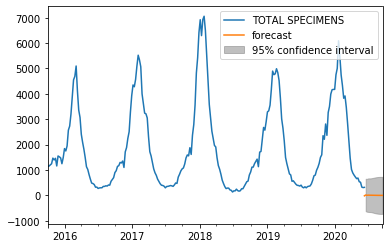

In [24]:
##Out of sample forecast 3,1,1
fig, ax = plt.subplots()
ax = FluCases2015.loc['2015':].plot(ax=ax)
fig = results1.plot_predict('2020-06-14', '2020-09-14', dynamic=True, ax=ax, plot_insample=False)
plt.show()

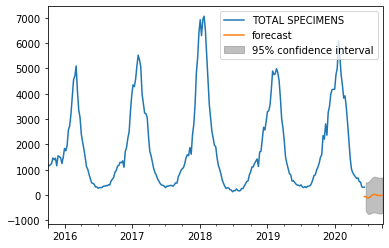

In [25]:
##Out of sample forecast 5,1,2
fig, ax = plt.subplots()
ax = FluCases2015.loc['2015':].plot(ax=ax)
fig = results2.plot_predict('2020-06-14', '2020-09-14', dynamic=True, ax=ax, plot_insample=False)
plt.show()

## SARIMAX

The brute force method to find optimal values of the ARIMA model above arrived at an ARIMA(3,1,1) with a single first order difference and seasonal difference of 52. These values can be used with the Seasonal Autoregressive Integrated Moving Average (SARIMA) method to directly model the apparent seasonal component.

In [26]:
model = SARIMAX(FluCases2015, 
                order=(3,0,1), 
                seasonal_order=(0,1,0,52))
model_fit = model.fit()

backcast52 = model_fit.predict(start=len(FluCases2015)-52, end=len(FluCases2015))
forecast12 = model_fit.predict(start=len(FluCases2015), end=len(FluCases2015)+12)

In [27]:
# Confirm backward and forward forecasts worked correctly by checking date indices.
print(backcast52.tail(3))
print(forecast12.head(3))

2020-06-07    242.559054
2020-06-14    254.423999
2020-06-21    336.514134
Freq: W-SUN, dtype: float64
2020-06-21    336.514134
2020-06-28    343.365655
2020-07-05    404.377468
Freq: W-SUN, dtype: float64


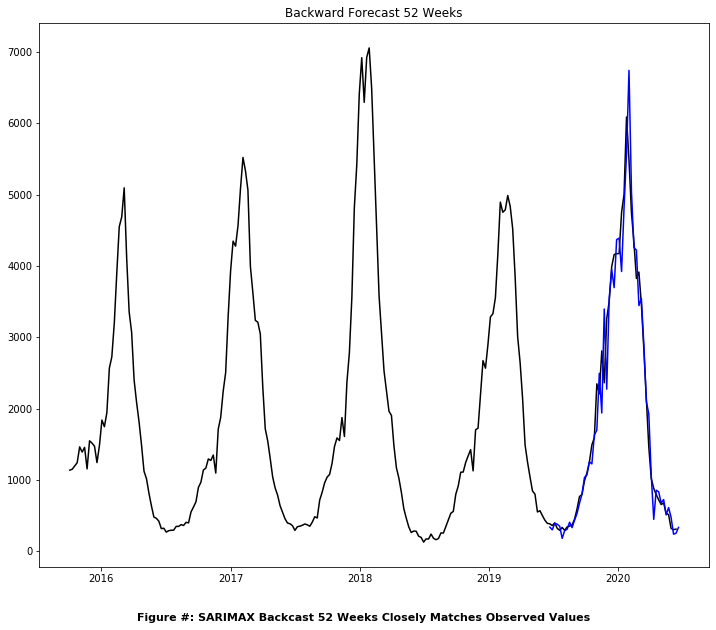

In [28]:
# Backward forecast
index_of_bc = np.arange(len(FluCases2015)-52, len(FluCases2015))
#bc_series = pd.Series(backcast52, index=index_of_bc)

plt.figure(figsize=(12,10))
plt.plot(FluCases2015, color='black')
plt.plot(backcast52, color='blue')
plt.title("Backward Forecast 52 Weeks")
caption = "Figure #: SARIMAX Backcast 52 Weeks Closely Matches Observed Values"
plt.figtext(0.5, 0.05, caption, ha='center', weight='bold', fontsize=11)
plt.show()

For demonstration purposes, the backcast is performed on 52 weeks' worth of data, shown by the blue line above. It closely follows the originally observed numbers for reported cases for that period, neither heavily over- or underestimating said vallues for extended periods of time, suggesting a good fit.

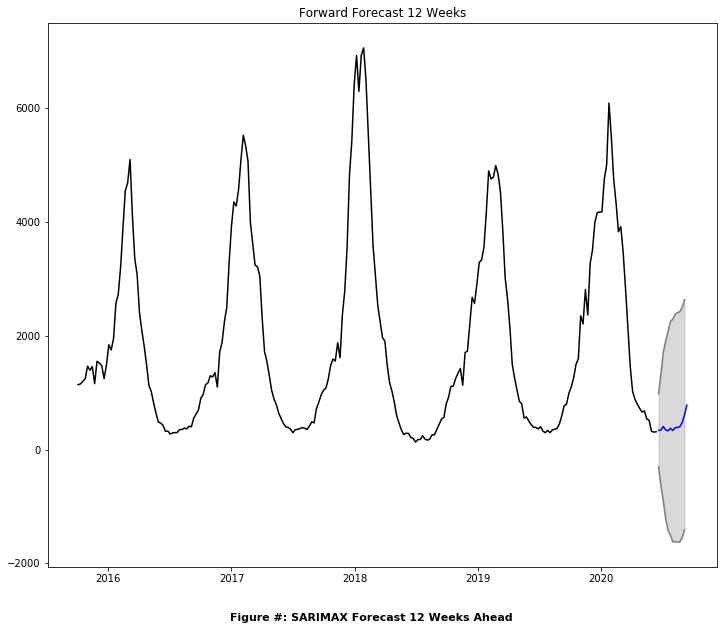

In [29]:
# Forward forecast
fcast = model_fit.get_forecast(12)
cis = fcast.conf_int()
cis.iloc[:,0]

plt.figure(figsize=(12,10))
plt.plot(FluCases2015, color='black')
plt.plot(forecast12, color='blue')
plt.plot(cis.iloc[:,0], color='gray')
plt.plot(cis.iloc[:,1], color='gray')
plt.fill_between(cis.iloc[:,0].index,
                cis.iloc[:,0],
                cis.iloc[:,1],
                color='k', alpha=.15)
plt.title("Forward Forecast 12 Weeks")
caption = "Figure #: SARIMAX Forecast 12 Weeks Ahead"
plt.figtext(0.5, 0.05, caption, ha='center', weight='bold', fontsize=11)
plt.show()

The forecast 12 weeks into the future is shown above with 95% confidence intervals. The behavior of this model closely mimics the appearance of the previous season.

## Conclusion

In summary, we determined there was a yearly seasonal trend to the data, with peaks in case counts in the beginning of the year and valleys in the middle. We took a first order difference of the data to model out this trend and create stationary data. Through some brute force testing we determined the optimal order for an ARIMA model is (3,1,1), with an AIC of 2797.082 and an MSE of 127005.735. 

The forecasts of these for the next 12 weeks appear to follow the mean of the ARIMA model. Since this follows close to the valley of the trend line, which accounts for the next 12 weeks, it is not clear how accurate this might be. Since we saw a high MSE in some lags when conducting rolling window ASE, this trend might continue in our model. In this case, the forecasts would not be accurate in t

# Appendix

In [30]:
from statsmodels.tsa.stattools import acf
acf(FluCases2015,nlags=52)
# acf values at lag 50, 51, 52
# 0.68973956,  0.69275023,  0.68004042

/Users/michaelwolfe/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


array([ 1.        ,  0.97504467,  0.92665527,  0.85579222,  0.76994931,
        0.67215429,  0.56430365,  0.44853279,  0.33298373,  0.21902828,
        0.11268304,  0.01257855, -0.07897028, -0.1646328 , -0.24241615,
       -0.31231541, -0.37384516, -0.42891787, -0.47603557, -0.51487862,
       -0.54475295, -0.56576353, -0.58222802, -0.59199586, -0.59773705,
       -0.59766693, -0.59178447, -0.5800408 , -0.56401655, -0.54181124,
       -0.51586998, -0.48279443, -0.44487637, -0.40151012, -0.35354878,
       -0.29969505, -0.24056698, -0.17641447, -0.10653608, -0.03303655,
        0.04577178,  0.12675533,  0.20975475,  0.2956557 ,  0.3798746 ,
        0.45767749,  0.52855921,  0.58778603,  0.63592138,  0.67057785,
        0.68973956,  0.69275023,  0.68004042])

We know from our previous model-building that the optimal seasonal decomposition is s=52. Given that we are trying to build a simple ARIMA model without seasonal components, we will "stationarize" the data by removing the seasonal component.

In [31]:
def test_stationarity(timeseries):
    fig=plt.figure(figsize=(10,6))
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation', fontsize=14, weight='bold')
    plt.xlabel('Time (Weekly Intervals)')
    plt.ylabel('Positive Flu Cases Reported')
    caption='Figure 5: Rolling Mean and Standard Deviation plotted against Original Time Series'
    plt.figtext(0.5, 0.025, caption, ha='center', weight='bold',fontsize=11)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

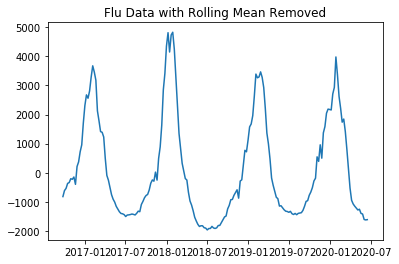

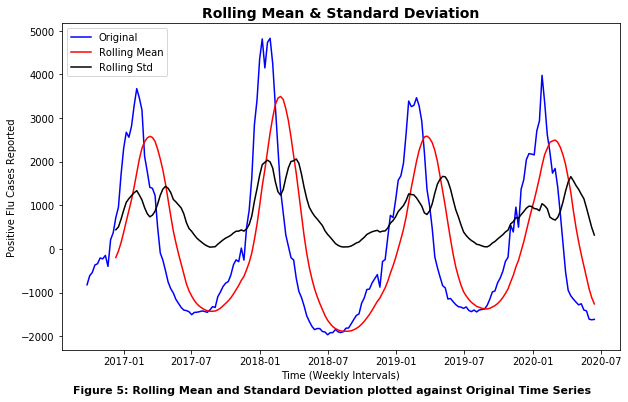

Results of Dickey-Fuller Test:
Test Statistic                  -4.250807
p-value                          0.000540
#Lags Used                      12.000000
Number of Observations Used    182.000000
Critical Value (1%)             -3.466800
Critical Value (5%)             -2.877555
Critical Value (10%)            -2.575308
dtype: float64


In [32]:
moving_avg = FluCases2015.rolling(52).mean()
FluCases2015Stat = FluCases2015 - moving_avg
plt.plot(FluCases2015Stat)
plt.title("Flu Data with Rolling Mean Removed")
test_stationarity(FluCases2015Stat.dropna())

We also took a second order difference of d=1 in our original analysis. We will replicate that here:

In [33]:
FluCases2015Diff = FluCases2015Stat-FluCases2015Stat.shift(1)

With the seasonal component removed, the data is much more stationary. We will proceed with the ARIMA model with these data. Since we established that the best order for ARUMA with s=52 is 5,0,2, we will try this order in our initial model.

                              ARMA Model Results                              
Dep. Variable:        TOTAL SPECIMENS   No. Observations:                  194
Model:                     ARMA(5, 2)   Log Likelihood               -1377.242
Method:                       css-mle   S.D. of innovations            292.290
Date:                Wed, 01 Jul 2020   AIC                           2772.484
Time:                        00:53:11   BIC                           2801.894
Sample:                    10-02-2016   HQIC                          2784.393
                         - 06-14-2020                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.0694     65.536     -0.032      0.975    -130.517     126.378
ar.L1.TOTAL SPECIMENS    -0.0523      0.123     -0.427      0.669      -0.292       0.188
ar.L2.TO

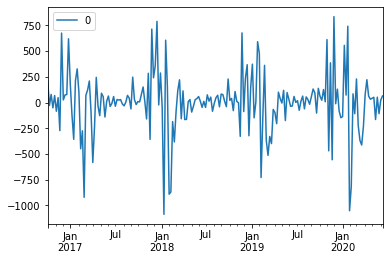

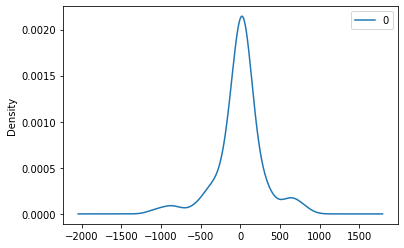

                 0
count   194.000000
mean     -0.880018
std     293.382829
min   -1085.987591
25%     -87.843600
50%      19.431772
75%      88.782602
max     834.300391


In [34]:
model = ARIMA(FluCases2015Diff.dropna(), order=(5,0,2), freq='W')
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

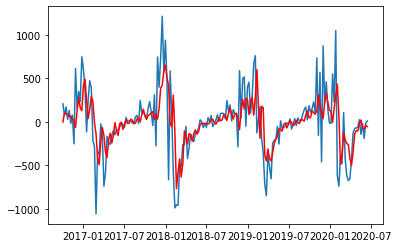

In [35]:
plt.plot(FluCases2015Diff)
plt.plot(model_fit.fittedvalues, color='red')


This looks reasonable. The frequency plot appears to be relatively evenly distributed - we are not seeing the out of season differences we saw in the raw data. The density is a Gaussian distribution without being overfit - this also bears out when overlaying the fitted values. We will next try in- and out-of-sample forecasts to test this model.

## Forecasting

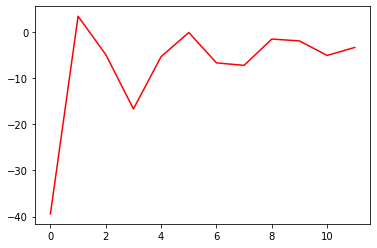

In [36]:
##Out Of Sample
fore = model_fit.forecast(steps=12, alpha=.1)[0]
plt.plot(fore, color='red')

In [37]:
X = FluCases2015Diff.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
error = mean_squared_error(test, predictions)
print(error)

140813.19689453102


The forecast of this model has an out of sample MSE of 140,813.249.

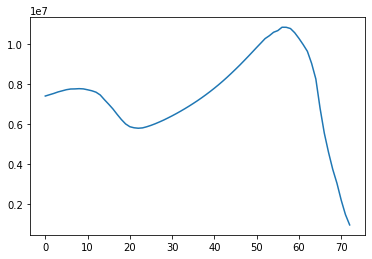

In [38]:
mses = rolling_mse(FluCases2015, model_fit, 12)
plt.plot(mses, label='Rolling Window MSE of SARIMAX')